In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Init OpticalData with {'ew_filepath': '../data/EW_Ridgecrest_1m_utm.tif', 'ns_filepath': '../data/NS_Ridgecrest_1m_utm.tif'}
Importing TIF files: ../data/EW_Ridgecrest_1m_utm.tif ../data/NS_Ridgecrest_1m_utm.tif
Imported EW data shape: (53626, 48648)
Imported NS data shape: (53626, 48648)

Decimating EW optical...
Decimating NS optical...
Decimated

Clearing NaNs...
... cleared.
Plotting...
Reprojecting into new coordinate system: EPSG:4326
... reprojected.
... plotted.


[<Figure size 700x600 with 2 Axes>,
 <Axes: xlabel='Latitude (˚)', ylabel='Longitude (˚)'>]

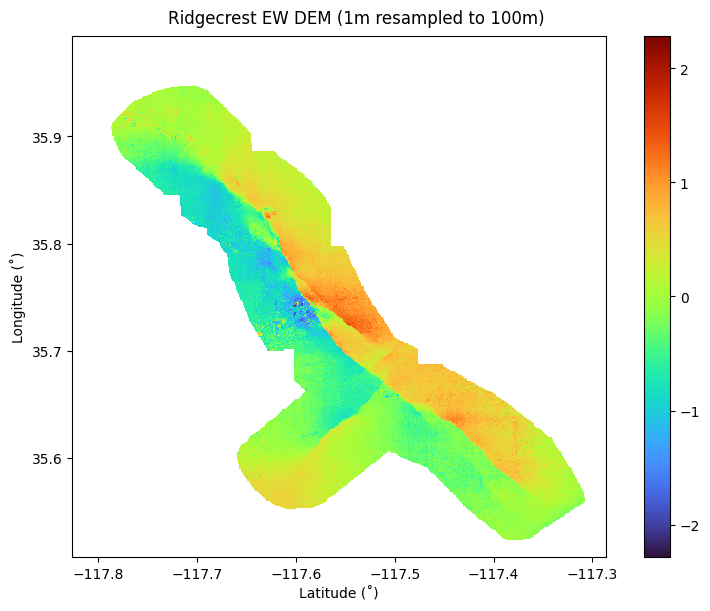

In [24]:
from codes import OpticalData

optical = OpticalData(ew_filepath="../data/EW_Ridgecrest_1m_utm.tif", ns_filepath="../data/NS_Ridgecrest_1m_utm.tif")
optical.decimate(100)
optical.clear_nan()
optical.plot(title="Ridgecrest EW DEM (1m resampled to 100m)", ns=False)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import rioxarray as rxr
optical_data = 
EW_data = rxr.open_rasterio("../data/EW_Ridgecrest_1m_utm.tif").squeeze("band", drop=True)
da = EW_data.isel(x=slice(0,None,100), y=slice(0,None,100))
da = da.where(da != 0.)

In [12]:
import geopandas as gpd
fault_geometry = gpd.read_file("/Users/hintont/Dev/projects/Ridgecrest/data/fault_trace.shp")
fault_geometry = fault_geometry.to_crs(EW_data.rio.crs)
fault_trace = fault_geometry.geometry.values

In [16]:
fault_geometry.geometry.values.length

array([43441.48522408])

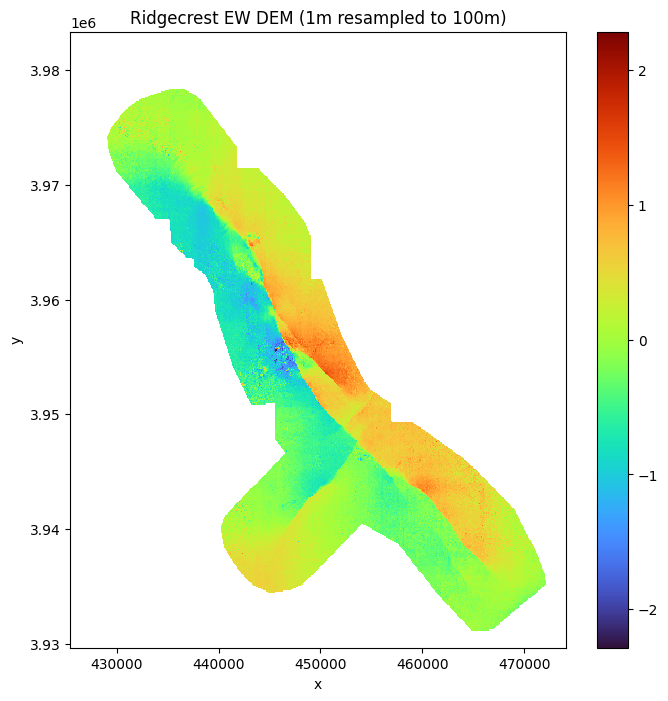

In [4]:
fig, ax = plt.subplots(figsize=(8,8))
im = da.plot(ax=ax, cmap="turbo", add_colorbar=True)
ax.set_title("Ridgecrest EW DEM (1m resampled to 100m)")
plt.show()

In [30]:
profile_half_length = 5000
profile_spacing = 5000

In [6]:
import numpy as np
from shapely.geometry import LineString, Point

def perpendicular_profile(line, distance, half_length):
    """
    Create a profile perpendicular to a LineString at a given distance.
    """
    point = line.interpolate(distance)

    # Small offset to estimate tangent
    eps = 1.0
    p1 = line.interpolate(max(distance - eps, 0))
    p2 = line.interpolate(min(distance + eps, line.length))

    dx = p2.x - p1.x
    dy = p2.y - p1.y

    # Normalized perpendicular direction
    length = np.hypot(dx, dy)
    nx = -dy / length
    ny = dx / length

    start = Point(
        point.x - nx * half_length,
        point.y - ny * half_length
    )
    end = Point(
        point.x + nx * half_length,
        point.y + ny * half_length
    )

    return LineString([start, end])

In [31]:
distances = np.arange(0, fault_trace.length[0], profile_spacing)

profiles = [
    perpendicular_profile(fault_trace, d, profile_half_length)
    for d in distances
]

profiles_gdf = gpd.GeoDataFrame(
    {"distance_along_fault": distances},
    geometry=profiles,
    crs=da.rio.crs
)


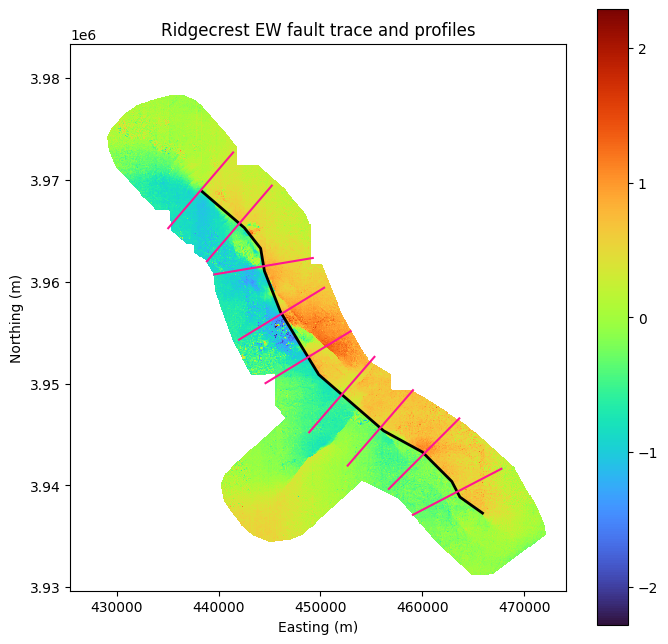

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
im = da.plot(ax=ax, cmap="turbo", add_colorbar=True)
ax.set_title("Ridgecrest EW fault trace and profiles")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
fault_geometry.plot(
    ax=ax,
    color="black",
    linewidth=2,
    label="Fault trace"
)
profiles_gdf.plot(
    ax=ax,
    color="deeppink",
    linewidth=1.5,
    alpha=1.,
    label="Profiles"
)
plt.show()

In [20]:
def sample_profile(da, line, npts=200):
    distances = np.linspace(-profile_half_length, profile_half_length, npts)

    xs = np.linspace(line.coords[0][0], line.coords[1][0], npts)
    ys = np.linspace(line.coords[0][1], line.coords[1][1], npts)

    values = da.interp(
        x=("points", xs),
        y=("points", ys),
        method="linear"
    ).values

    return distances, values


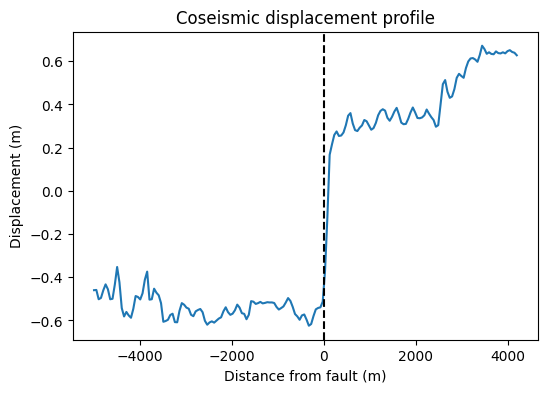

In [34]:
d, v = sample_profile(da, profiles[5])

plt.figure(figsize=(6, 4))
plt.plot(d, v)
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Distance from fault (m)")
plt.ylabel("Displacement (m)")
plt.title("Coseismic displacement profile")
plt.show()